In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from xgboost.sklearn import XGBRegressor 
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import BaggingRegressor
import math
sns.set()

In [ ]:
#Read files:
train = pd.read_csv("/content/drive/MyDrive/datahack.av/train_v9rqX0R.csv")
test = pd.read_csv("/content/drive/MyDrive/datahack.av/test_AbJTz2l.csv")

In [ ]:
train.head()

Item_Identifier  Item_Weight  ...        Outlet_Type  Item_Outlet_Sales
0           FDA15         9.30  ...  Supermarket Type1          3735.1380
1           DRC01         5.92  ...  Supermarket Type2           443.4228
2           FDN15        17.50  ...  Supermarket Type1          2097.2700
3           FDX07        19.20  ...      Grocery Store           732.3800
4           NCD19         8.93  ...  Supermarket Type1           994.7052

[5 rows x 12 columns]

In [ ]:
#Setting train flag and Merging Datasets
train['is_train'] = 1
test['is_train'] = 0
test['Item_Outlet_Sales'] = None

In [ ]:
data = pd.concat((train,test))
data.shape

(14204, 13)

In [ ]:
data.describe().T


count         mean  ...          75%          max
Item_Weight                11765.0    12.792854  ...    16.750000    21.350000
Item_Visibility            14204.0     0.065953  ...     0.094037     0.328391
Item_MRP                   14204.0   141.004977  ...   185.855600   266.888400
Outlet_Establishment_Year  14204.0  1997.830681  ...  2004.000000  2009.000000
is_train                   14204.0     0.600042  ...     1.000000     1.000000

[5 rows x 8 columns]

In [ ]:
#Data Cleaning
data['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [ ]:
data['Item_Fat_Content'].replace( {'low fat':'Low Fat', 'LF':'Low Fat', 'reg':'Regular'}, inplace=True)

In [ ]:
data.head()

Item_Identifier  Item_Weight  ... Item_Outlet_Sales  is_train
0           FDA15         9.30  ...           3735.14         1
1           DRC01         5.92  ...           443.423         1
2           FDN15        17.50  ...           2097.27         1
3           FDX07        19.20  ...            732.38         1
4           NCD19         8.93  ...           994.705         1

[5 rows x 13 columns]

In [ ]:
#Missing Value Analysis
data.isna().sum()/data.shape[0]*100

Item_Identifier               0.000000
Item_Weight                  17.171219
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.273726
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales            39.995776
is_train                      0.000000
dtype: float64

In [ ]:
# Finding Relation Between "Item_Identifier" and 'Item_Weight'

data[ data['Item_Identifier'] == 'FDA15']

Item_Identifier  Item_Weight  ... Item_Outlet_Sales  is_train
0              FDA15          9.3  ...           3735.14         1
831            FDA15          9.3  ...           5976.22         1
2599           FDA15          9.3  ...           6474.24         1
2643           FDA15          9.3  ...           5976.22         1
4874           FDA15          9.3  ...           498.018         1
5413           FDA15          9.3  ...           6474.24         1
6696           FDA15          NaN  ...           6474.24         1
7543           FDA15          9.3  ...           5976.22         1
1115           FDA15          9.3  ...              None         0

[9 rows x 13 columns]

In [ ]:
# Creating Dictionary : { 'Item_Identifier' : 'Iten_Weight'(mode)}

weight_dict = data.groupby('Item_Identifier')['Item_Weight'].agg(pd.Series.mode).to_dict()

In [ ]:
#Imputing "Item_Weight" by mode 'Item_Weight' value for particular "Item_Identifier"

data.loc[ data['Item_Weight'].isna(), 'Item_Weight'] = data[ data['Item_Weight'].isna()]['Item_Identifier'].apply(lambda x: weight_dict[x])

In [ ]:
data.head()

Item_Identifier  Item_Weight  ... Item_Outlet_Sales  is_train
0           FDA15         9.30  ...           3735.14         1
1           DRC01         5.92  ...           443.423         1
2           FDN15        17.50  ...           2097.27         1
3           FDX07        19.20  ...            732.38         1
4           NCD19         8.93  ...           994.705         1

[5 rows x 13 columns]

In [ ]:
data['Outlet_Size'].value_counts()

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

In [ ]:
data['Outlet_Identifier'].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [ ]:
data[ data['Outlet_Size'].isna()].groupby('Outlet_Identifier')['Outlet_Establishment_Year'].value_counts()

Outlet_Identifier  Outlet_Establishment_Year
OUT010             1998                          925
OUT017             2007                         1543
OUT045             2002                         1548
Name: Outlet_Establishment_Year, dtype: int64

In [ ]:
data['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [ ]:
data['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [ ]:
data[ data['Outlet_Type'] == 'Grocery Store']['Outlet_Size'].value_counts()

Small    880
Name: Outlet_Size, dtype: int64

In [ ]:
data[ data['Outlet_Type'] == 'Supermarket Type1']['Outlet_Size'].value_counts()

Small     3100
High      1553
Medium    1550
Name: Outlet_Size, dtype: int64

In [ ]:
data[ data['Outlet_Type'] == 'Supermarket Type2']['Outlet_Size'].value_counts()

Medium    1546
Name: Outlet_Size, dtype: int64

In [ ]:
data[ data['Outlet_Type'] == 'Supermarket Type3']['Outlet_Size'].value_counts()

Medium    1559
Name: Outlet_Size, dtype: int64

In [ ]:
data[ data['Outlet_Size'].isna()]['Outlet_Type'].value_counts()

Supermarket Type1    3091
Grocery Store         925
Name: Outlet_Type, dtype: int64

In [ ]:
#Insight:
#All the Grocery Stores have Small 'Outlet_Size'.

#So we will impute missing values of 'Outlet_Size' as Small for rows which have 'Outlet_Type' as Grocery Store
data.loc[ (data['Outlet_Size'].isna()) & (data['Outlet_Type'] == 'Grocery Store'), 'Outlet_Size'] = 'Small'

In [ ]:
data[ data['Outlet_Type'] == 'Grocery Store']['Outlet_Size'].value_counts()

Small    1805
Name: Outlet_Size, dtype: int64

In [ ]:
data[ data['Outlet_Size'].isna()]['Outlet_Type'].value_counts()

Supermarket Type1    3091
Name: Outlet_Type, dtype: int64

In [ ]:
data[ data['Outlet_Type'] == 'Supermarket Type1']#['Outlet_Size'].value_counts()


Item_Identifier  Item_Weight  ... Item_Outlet_Sales  is_train
0              FDA15         9.30  ...           3735.14         1
2              FDN15        17.50  ...           2097.27         1
4              NCD19         8.93  ...           994.705         1
6              FDO10        13.65  ...           343.553         1
8              FDH17        16.20  ...            1076.6         1
...              ...          ...  ...               ...       ...
5675           FDW46        13.00  ...              None         0
5676           FDB58        10.50  ...              None         0
5678           NCO17        10.00  ...              None         0
5679           FDJ26        15.30  ...              None         0
5680           FDU37         9.50  ...              None         0

[9294 rows x 13 columns]

In [ ]:
data[ data['Outlet_Size'].isna()]['Outlet_Location_Type'].value_counts()

Tier 2    3091
Name: Outlet_Location_Type, dtype: int64

 **Insight:**
All missing values of 'Outlet_Size' have 'Outlet_Type' as 'Supermarket Type1'.

After grouping with 'Outlet_Type' = 'Supermarket Type1' & 'Outlet_Location_type' we can see that Tier 2 have Small 'Outlet_Size'.

So, we will impute missing values of 'Outlet_Size' with the help of these observations.

In [ ]:
data.loc[ (data['Outlet_Size'].isna()) & (data['Outlet_Location_Type'] == 'Tier 2'), 'Outlet_Size'] = 'Small'

In [ ]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
is_train                        0
dtype: int64

**Variable Analysis**

In [ ]:
#Categorical Variables
col_cat = ['Item_Fat_Content','Item_Type','Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type','Outlet_Type']

TypeError: ignored

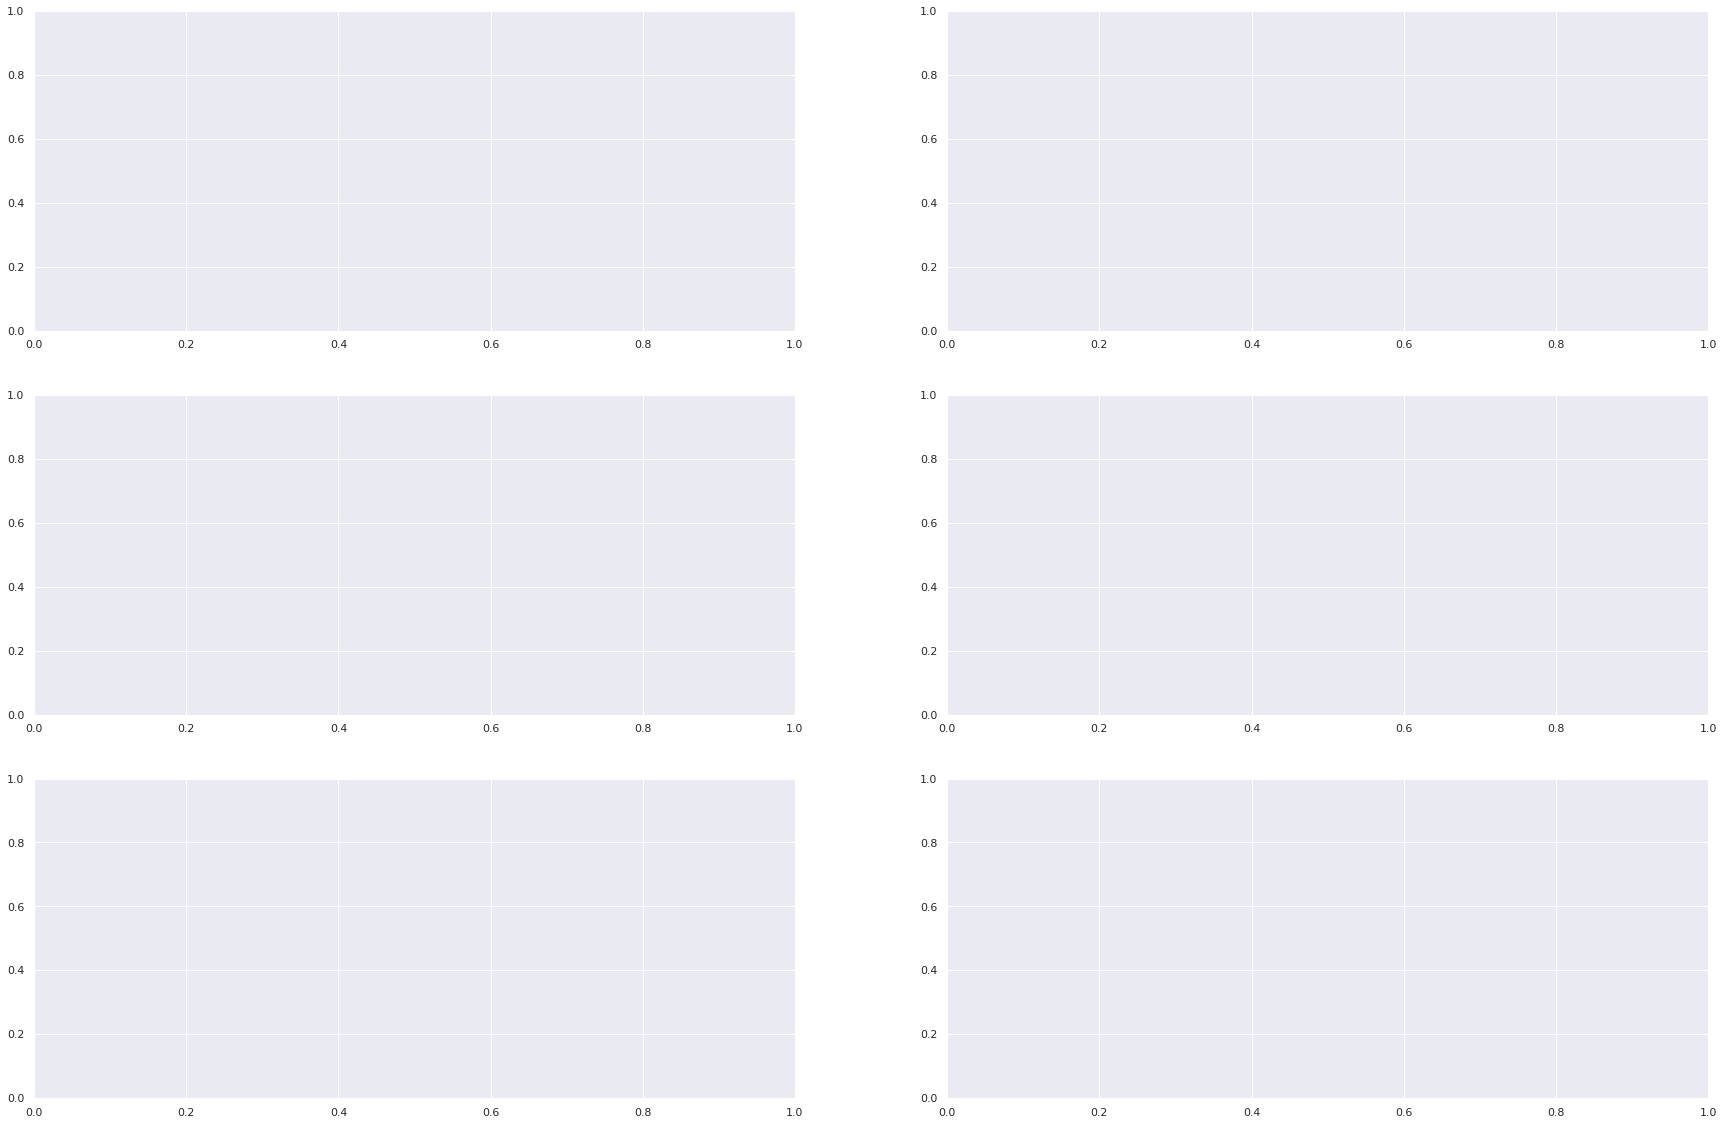

In [ ]:
f, ax = plt.subplots(nrows = 3, ncols=2,figsize = (30,20))
axx = ax.flatten()
for pos,col in enumerate(col_cat):
    sns.boxplot(y = data['Item_Outlet_Sales'],x = data[col],ax = axx[pos])

**Numerical variables**

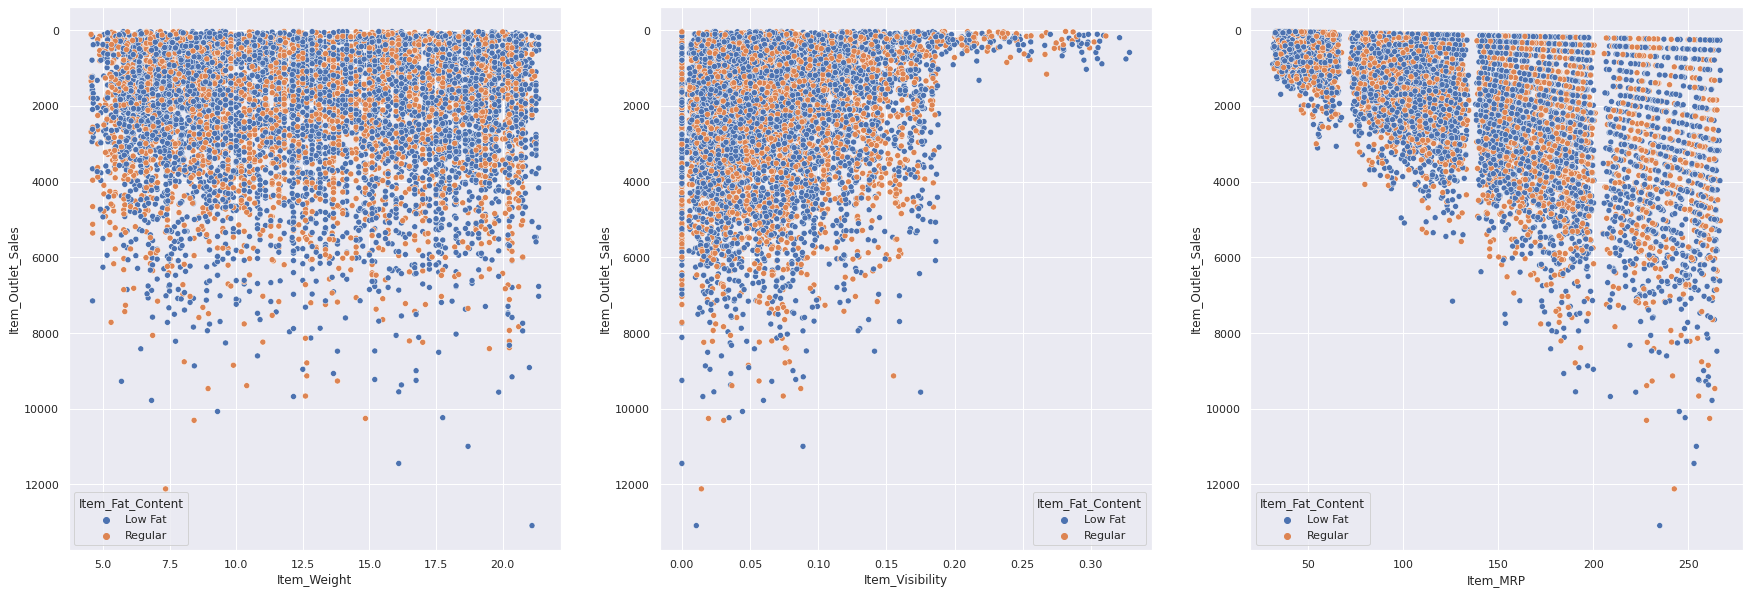

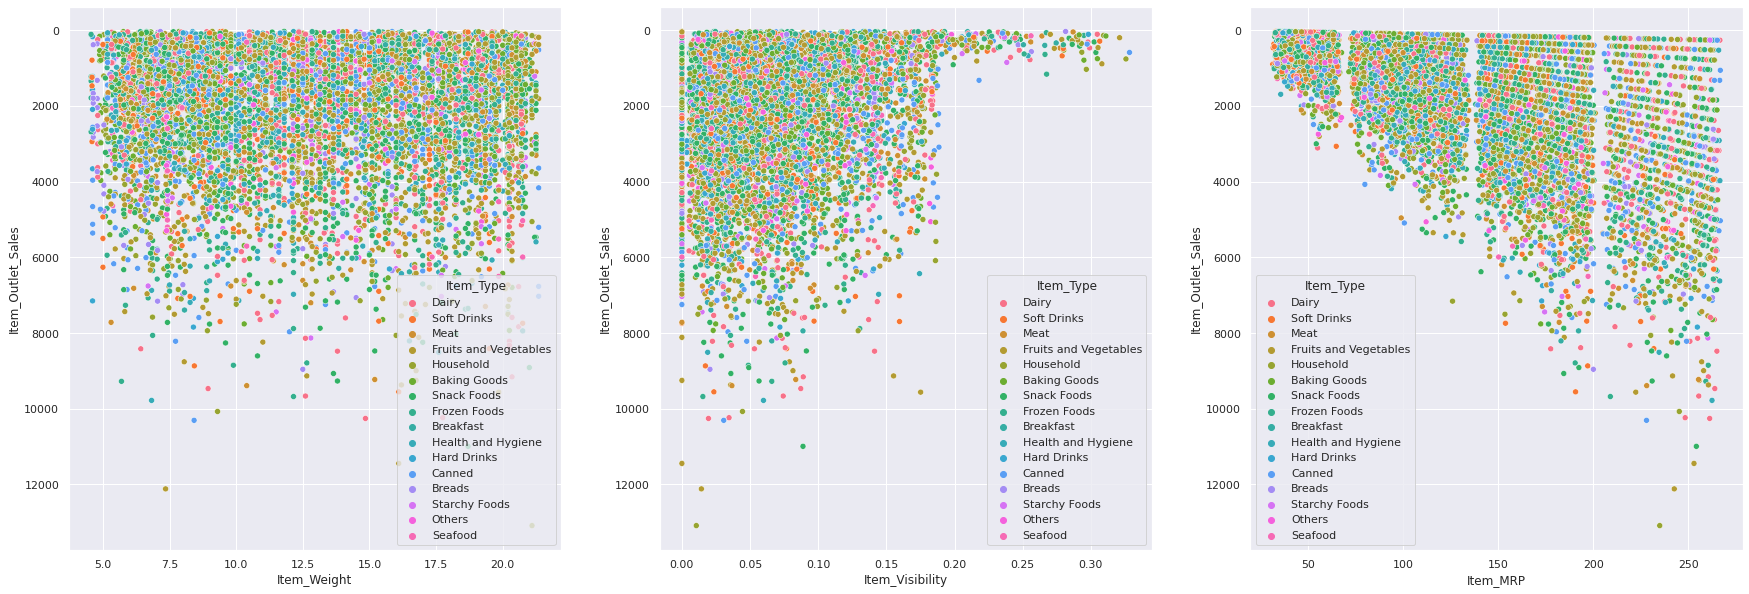

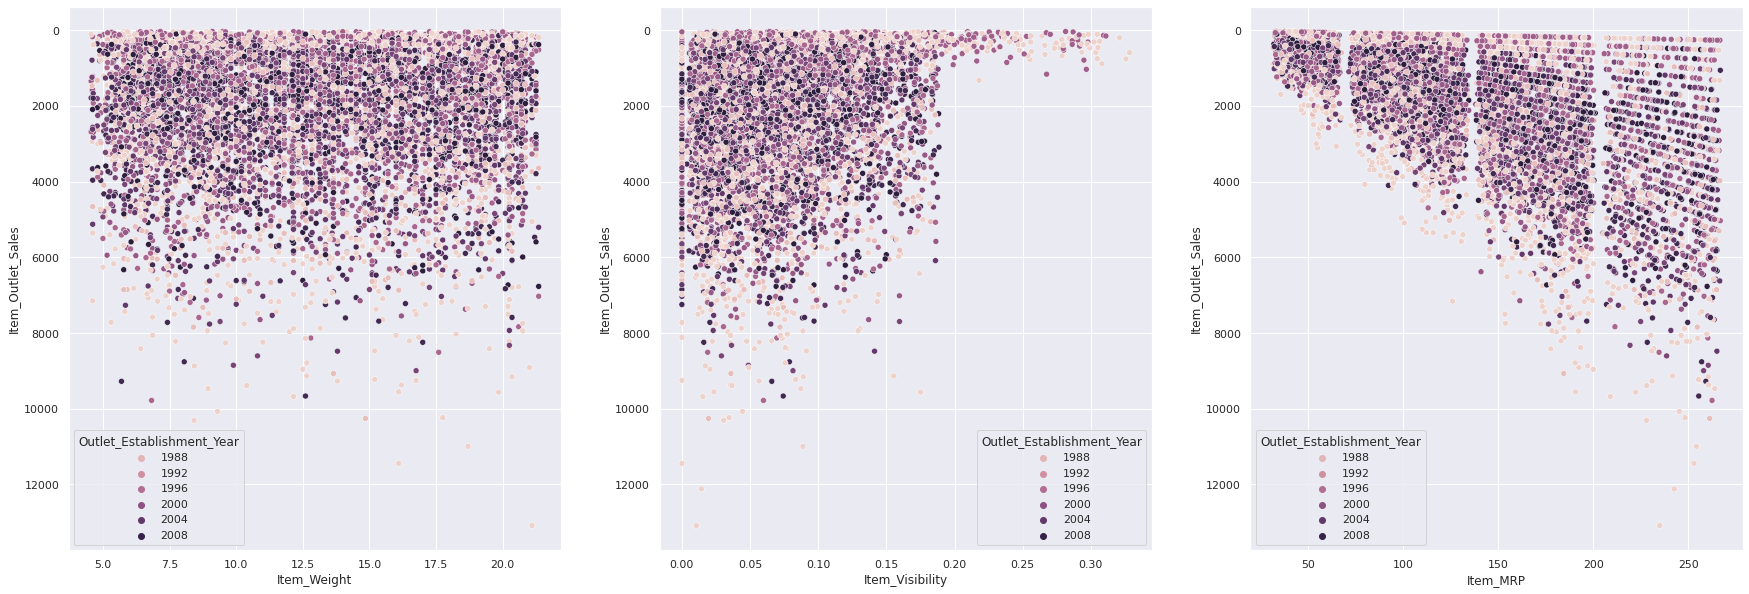

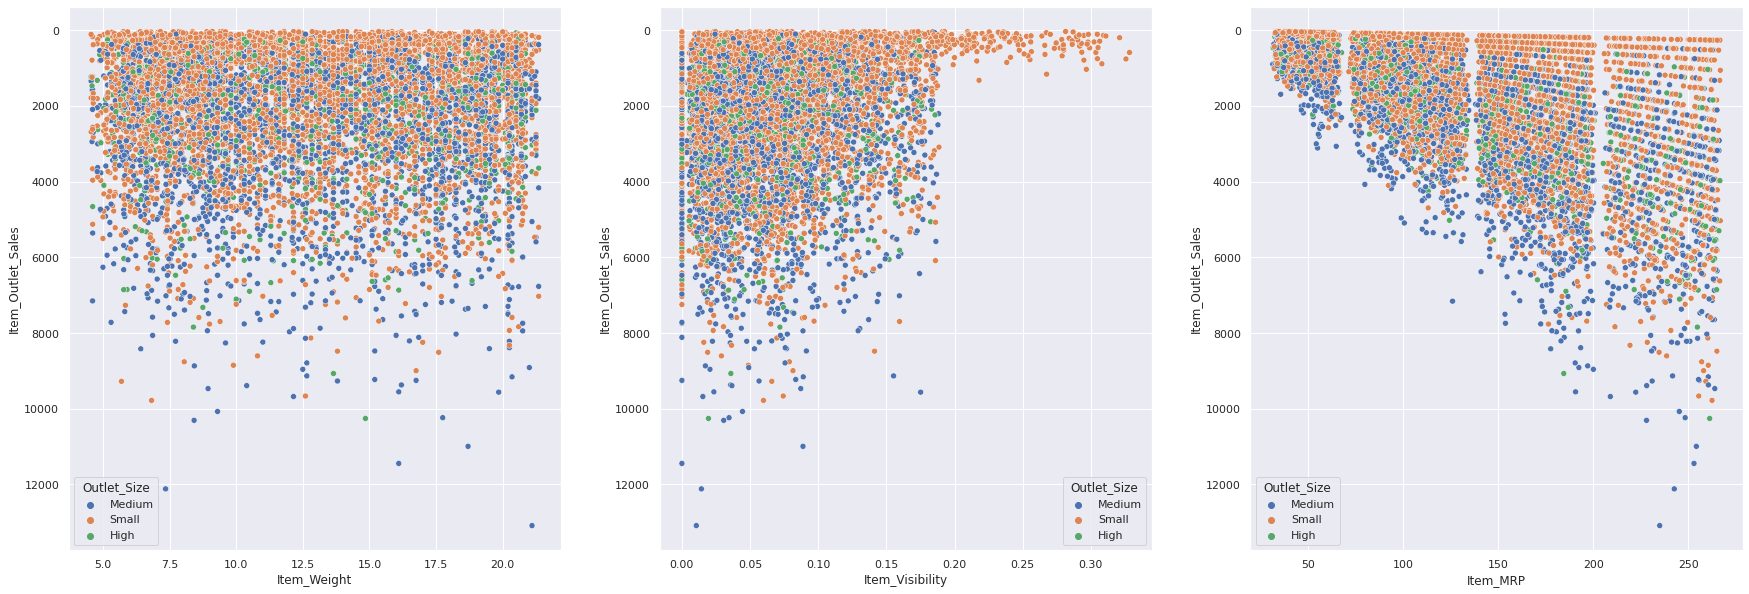

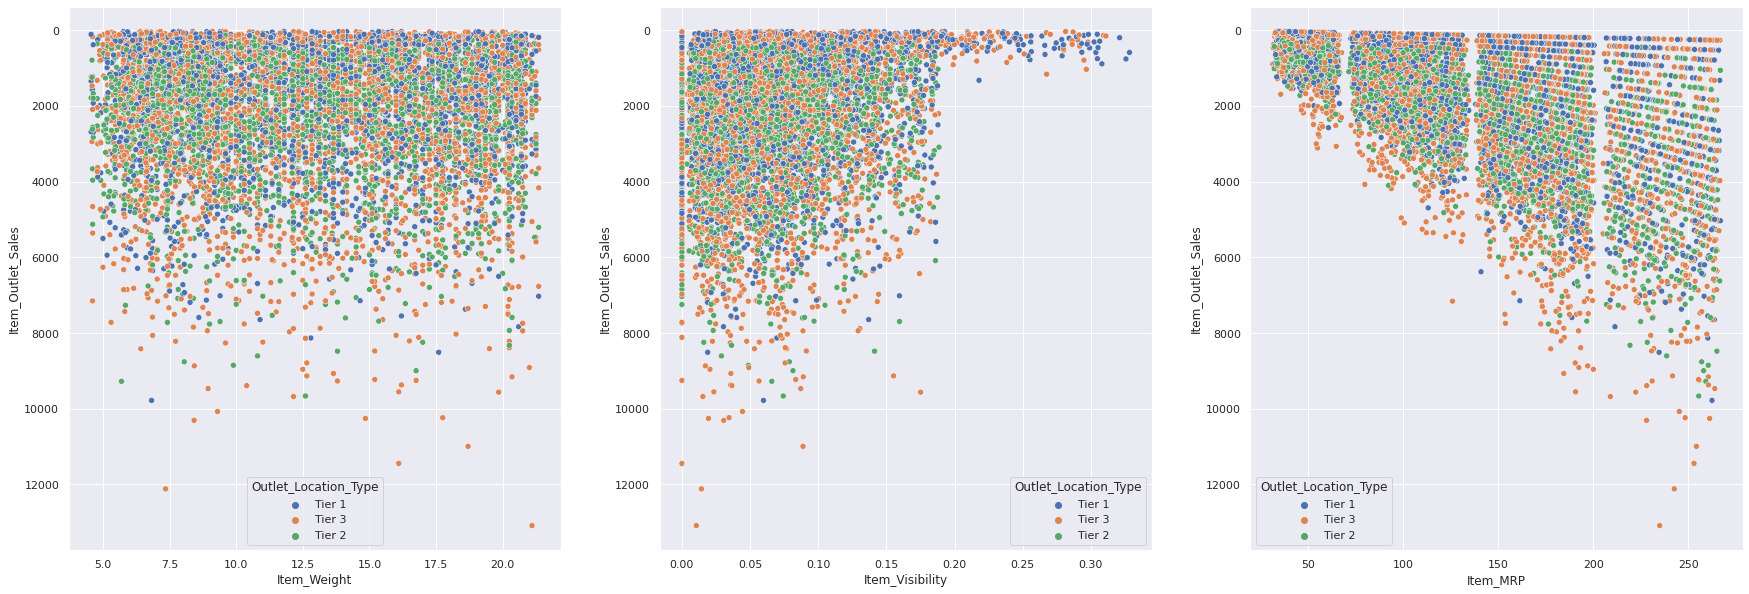

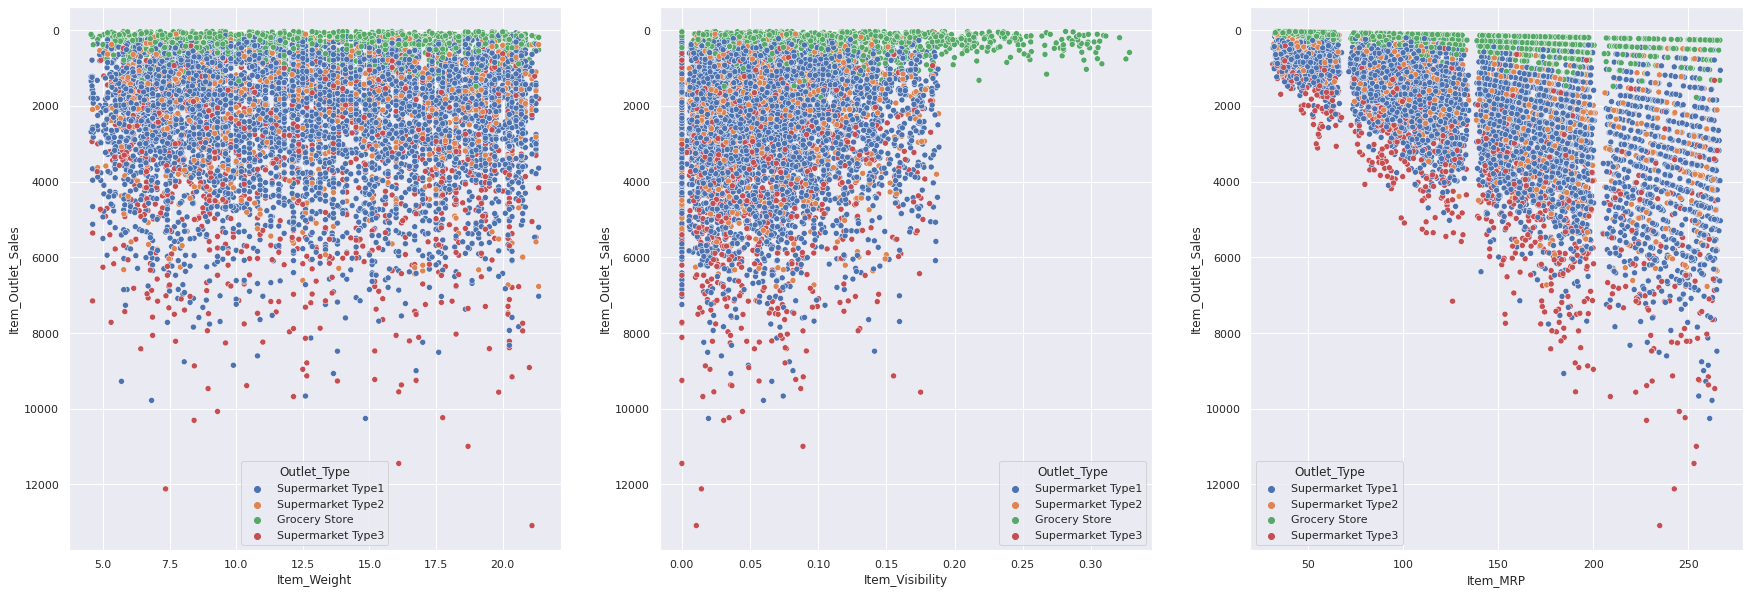

In [ ]:
col_num = ['Item_Weight', 'Item_Visibility','Item_MRP']

for cat in col_cat:
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,10))
    axx = ax.flatten()
    for pos,col in enumerate(col_num):
        sns.scatterplot(y = data['Item_Outlet_Sales'],x = data[col],ax = axx[pos], hue = data[cat] )

In [ ]:
#Replacing "Item_Visibility" = 0 with median value of 'Item_Visibility' of same 'Item_Type'

data[ data['Item_Visibility'] == 0]

Item_Identifier  Item_Weight  ... Item_Outlet_Sales  is_train
3              FDX07       19.200  ...            732.38         1
4              NCD19        8.930  ...           994.705         1
5              FDP36       10.395  ...           556.609         1
10             FDY07       11.800  ...           1516.03         1
32             FDP33       18.700  ...           3068.01         1
...              ...          ...  ...               ...       ...
5643           FDQ19        7.350  ...              None         0
5648           FDK26        5.460  ...              None         0
5654           FDQ57        7.275  ...              None         0
5661           DRG37       16.200  ...              None         0
5679           FDJ26       15.300  ...              None         0

[879 rows x 13 columns]

In [ ]:
print(data[ data['Item_Type'] == 'Baking Goods']['Item_Visibility'].mean())
print(data[ data['Item_Type'] == 'Baking Goods']['Item_Visibility'].median())

0.06789758671915273
0.0600083505


In [ ]:
# Creating dictionary

item_visibility = data.groupby('Item_Type')['Item_Visibility'].median().to_dict()

In [ ]:
item_visibility

{'Baking Goods': 0.0600083505,
 'Breads': 0.05665598349999999,
 'Breakfast': 0.0662432875,
 'Canned': 0.05036144299999999,
 'Dairy': 0.06175574,
 'Frozen Foods': 0.0568679555,
 'Fruits and Vegetables': 0.05507343,
 'Hard Drinks': 0.0584279255,
 'Health and Hygiene': 0.0459575045,
 'Household': 0.0446384245,
 'Meat': 0.0427579805,
 'Others': 0.047033756499999996,
 'Seafood': 0.054245722,
 'Snack Foods': 0.056328717,
 'Soft Drinks': 0.051003163500000004,
 'Starchy Foods': 0.060836524}

In [ ]:
data.loc[ (data['Item_Visibility'] == 0), 'Item_Visibility'] = data[ data['Item_Visibility'] == 0]['Item_Type'].apply(lambda x: item_visibility[x])

**Outlier Analysis**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                14204 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                14204 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   object 
 12  is_train                   14204 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage

In [ ]:
col_ls = data.select_dtypes(exclude='object').columns

In [ ]:
col_ls = col_ls[:-2]
col_ls

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Ver

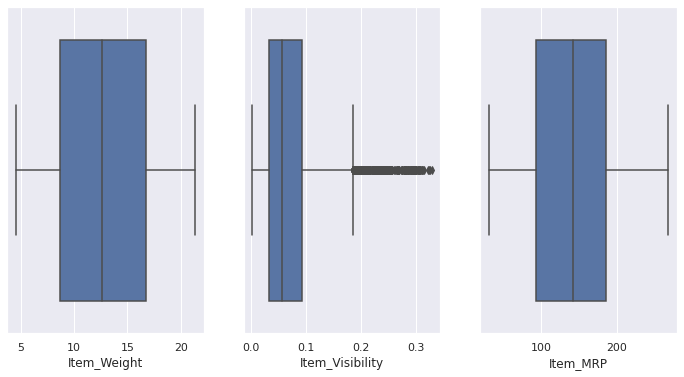

In [ ]:
f,ax = plt.subplots(nrows=1,ncols=3,figsize = (12,6))
axx = ax.flatten()
for pos,col in enumerate(col_ls):
    sns.boxplot(data[col], ax = axx[pos],orient='v')


In [ ]:
#Removing Outliers in 'Item_Visibility'

data.loc[ (data['Item_Visibility'] >0.185), 'Item_Visibility'] = data[ data['Item_Visibility'] > 0.185]['Item_Type'].apply(lambda x: item_visibility[x])

In [ ]:
data.loc[ (data['Item_Visibility'] >0.175)]

Item_Identifier  Item_Weight  ... Item_Outlet_Sales  is_train
126            DRI49       14.150  ...           1137.19         1
179            FDO24       11.100  ...           3010.75         1
259            FDS12        9.100  ...           4655.94         1
359            FDJ56        8.985  ...           2696.49         1
393            FDU02       13.350  ...           916.141         1
...              ...          ...  ...               ...       ...
5205           DRI49       14.150  ...              None         0
5462           NCE31        7.670  ...              None         0
5473           FDD52       18.250  ...              None         0
5568           FDO27        6.175  ...              None         0
5601           NCO53       16.200  ...              None         0

[138 rows x 13 columns]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Ver

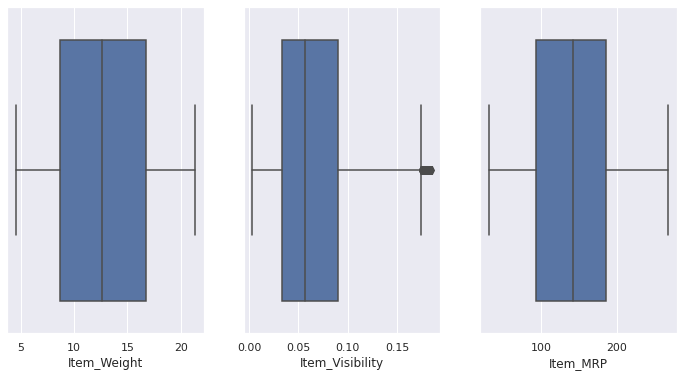

In [ ]:
f,ax = plt.subplots(nrows=1,ncols=3,figsize = (12,6))
axx = ax.flatten()
for pos,col in enumerate(col_ls):
    sns.boxplot(data[col], ax = axx[pos],orient='v')


**See we have reduced the errors in item Visibilty**

TypeError: ignored

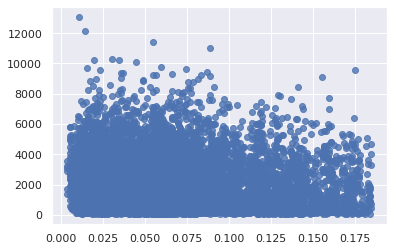

In [ ]:
sns.regplot(x='Item_Visibility',y='Item_Outlet_Sales',data=data)

**Exporting Prepared Data**

In [ ]:
data.to_csv("concat_data.csv", index=False)

In [ ]:
data = pd.read_csv(r"concat_data.csv")

**One Hot Encoding**

In [ ]:
data.drop(['Outlet_Establishment_Year'],axis = 1,inplace=True)

In [ ]:
cat_col = data.select_dtypes(include='object').columns

In [ ]:
cat_col

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [ ]:
data = pd.get_dummies(data = data,columns = cat_col, drop_first=True)
data.shape

(14204, 1595)

In [ ]:
data.head()

Item_Weight  ...  Outlet_Type_Supermarket Type3
0         9.30  ...                              0
1         5.92  ...                              0
2        17.50  ...                              0
3        19.20  ...                              0
4         8.93  ...                              0

[5 rows x 1595 columns]

In [ ]:
scaler = MinMaxScaler()

In [ ]:
col_ls = ['Item_Weight','Item_MRP']

In [ ]:
data[col_ls] = scaler.fit_transform(data[col_ls])

In [ ]:
print(data.duplicated().sum())

0


**Model Building(Final Prediction)**

In [ ]:
train1 = data[ data['is_train'] == 1]
test1 = data[ data['is_train'] == 0]

In [ ]:
train1.drop(['is_train'], inplace=True, axis=1)
test1.drop(['is_train'], inplace=True, axis=1)
test1.drop(['Item_Outlet_Sales'], inplace=True, axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train1 = train1[ [col for col in train1 if col!='Item_Outlet_Sales'] + ['Item_Outlet_Sales']]

In [ ]:
X_train = train1.iloc[:,:-1]
y_train = train1.iloc[:,-1]
X_test = test1

In [ ]:
X_test.reset_index(drop=True)

Item_Weight  ...  Outlet_Type_Supermarket Type3
0        0.964275  ...                              0
1        0.222983  ...                              0
2        0.598095  ...                              0
3        0.164335  ...                              0
4        0.538553  ...                              1
...           ...  ...                            ...
5676     0.353974  ...                              0
5677     0.181304  ...                              0
5678     0.324204  ...                              0
5679     0.639774  ...                              0
5680     0.294433  ...                              0

[5681 rows x 1593 columns]

**Random Forest After Hyperparaeter Tuning (Best Accuracy on test data)**

In [ ]:
model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

**XGBoost**

In [ ]:
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=-1, nthread=None, random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=1)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[18:34:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Bagging**

In [ ]:
dt = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=62,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=41, min_samples_split=93,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
model = BaggingRegressor(base_estimator=dt, n_estimators=500, random_state=0)

In [ ]:

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
sample_sub = pd.read_csv(r"/content/drive/MyDrive/datahack.av/sample_submission_8RXa3c6.csv")

In [ ]:
submit = sample_sub.copy()

In [ ]:
submit['Item_Outlet_Sales'] = y_pred


In [ ]:
submit

Item_Identifier Outlet_Identifier  Item_Outlet_Sales
0              FDW58            OUT049        1639.422590
1              FDW14            OUT017        1489.874999
2              NCN55            OUT010         610.611835
3              FDQ58            OUT017        2553.864760
4              FDY38            OUT027        6199.270203
...              ...               ...                ...
5676           FDB58            OUT046        2083.128011
5677           FDD47            OUT018        2424.538078
5678           NCO17            OUT045        2016.301909
5679           FDJ26            OUT017        3759.024136
5680           FDU37            OUT045        1371.205832

[5681 rows x 3 columns]

In [ ]:
min(y_pred)

152.34922309338282

**Eliminating Negative Values When Needed by Replacing with Random Forest predictions**

In [ ]:
if min(y_pred)<0:
    ind = submit[submit['Item_Outlet_Sales']<0].index
    model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.iloc[ind])
    submit.loc[ (submit['Item_Outlet_Sales']<0), 'Item_Outlet_Sales'] = y_pred

In [ ]:
submit.to_csv(r"Mysubmit.csv", index=False)